# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки
   - RowNumber — индекс строки в данных
   - CustomerId — уникальный идентификатор клиента
   - Surname — фамилия
   - CreditScore — кредитный рейтинг
   - Geography — страна проживания
   - Gender — пол
   - Age — возраст
   - Tenure — сколько лет человек является клиентом банка
   - Balance — баланс на счёте
   - NumOfProducts — количество продуктов банка, используемых клиентом
   - HasCrCard — наличие кредитной карты
   - IsActiveMember — активность клиента
   - EstimatedSalary — предполагаемая зарплата
   
Целевой признак
   - Exited — факт ухода клиента

Перед нами - задача бинарной классификации

## Подготовка данных

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder # это для порядкого кодирования
from sklearn.preprocessing import StandardScaler # это для масштабирвоания
from sklearn.model_selection import train_test_split # это для разделения на обучающую и валидационную выборку
from sklearn.metrics import f1_score # метрика f1-мера
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle # это для "перетасовывания" строк
from sklearn.metrics import roc_auc_score # метрика auc-roc
from sklearn.metrics import roc_curve # для графика roc-кривой
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Загрузим данные:

In [2]:
data = pd.read_csv('Churn.csv')

In [3]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Посмотрим информацию о датафрейме:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Пропуски в одном столбце - Tenure

Уберем заглавные буквы

In [5]:
data.columns = data.columns.str.lower()

Надо что-то сделать с пропусками в столбце Tenure. Думаю, можно заполнить пропуски медианой по стране

In [6]:
data['tenure'] = data.groupby("geography")['tenure'].transform(lambda x: x.fillna(x.median()))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Я бы удалил следующие столбцы:

    - RowNomber - зачем нам повтор индексов?
    - Surname - фамилия вряд-ли будет влиять на отток клиентов
    - Id клиента тоже не влияет

In [8]:
data = data.drop(['surname', 'customerid', 'rownumber'], axis=1)

In [9]:
data

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Далее мы имеем два категориальных столбца - страна и пол. Воспользуемся порядковым кодированием, чтобы преобразовать категории в цифры 

In [10]:
encoder = OrdinalEncoder(dtype=np.int64) # создали объект
data[['geography', 'gender']] = encoder.fit_transform(data[["geography", "gender"]])
# вызываем метод fit_transform для географии и пола


In [11]:
data

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,0,0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2,0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1.0,0.00,2,0,0,93826.63,0
4,850,2,0,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,39,5.0,0.00,2,1,0,96270.64,0
9996,516,0,1,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,0,0,36,7.0,0.00,1,0,1,42085.58,1
9998,772,1,1,42,3.0,75075.31,2,1,0,92888.52,1


Так же я бы сделал масштабирование признаков, потому что в столбце "баланс" у нас числа большие, в "кредитном рейтинге" числа меньше, а в "возрасте" еще меньше. Иначе мы попадем в ловушку. Но это после разбиения на выборки

Посмотрим на баланс классов:

In [12]:
data['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

### Выводы

Прочитали данные и выяснили:

- столбцы с фамилией, порядковым номером и ай клиентов нас не инетерсуют - удалили
- обнаружили пропуски в столбце tenure - и заполнили их по медиане соответствующей страны
- обнаружили два категориальных столбца: пол и страна - применили к ним порядковое кодирование
- имеется дисбаланс классов, ушедших в 4 раза меньше, чем оставшихся

Переходим к следующим этапам

## Исследование задачи

Разделим наши данные на выборки:

In [13]:
features = data.drop('exited', axis=1)
target = data['exited']

In [14]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345)

In [15]:
features_valid, features_test, target_valid , target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

Теперь можно приступить к масштабированию

In [16]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary'] # столбцы для масштабирования

In [17]:
# масштабирование
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


Scaler обучили только на тренировочной части данных

Теперь можно приступать к обучению без учета баланса

### Решающее дерево

В качестве метрики будем использовать f1-меру

In [18]:
my_result = {'depth' : [], 'result' : []}
for depth in range(1,16): #перебираем глубину
    model_tree = DecisionTreeClassifier(max_depth = depth, random_state=12345) # определяем модель
    model_tree.fit(features_train, target_train) # учим
    predictions_valid = model_tree.predict(features_valid) # предсказываем
    result = f1_score(target_valid, predictions_valid) # оцениваем качество
    my_result['depth'].append(depth)
    my_result['result'].append(result)
tree = pd.DataFrame(data=my_result)  

In [19]:
tree.loc[tree['result'] == tree['result'].max()]

,depth,result
3,4,0.55287


### Случайный лес

In [20]:
my_result_forest = {'n_estimators' : [], 'depth' : [], 'result' : []}
for est in range(10, 121, 10):
    for depth in range(1,16):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train)
        predictions_valid = model_forest.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        my_result_forest['n_estimators'].append(est)
        my_result_forest['depth'].append(depth)
        my_result_forest['result'].append(result) 
forest = pd.DataFrame(data=my_result_forest)        

In [21]:
forest.loc[forest['result'] == forest['result'].max()]

,n_estimators,depth,result
146,100,12,0.576271


Случаный лес дает лучший результат

Таким образом, лучший результат f1-меры - 0.5762. По заданию нам надо довести результат до 0.59. Давайте поработем с балансом классов

In [22]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=12)
model_forest.fit(features_train, target_train)
predictions_valid = model_forest.predict(features_valid)
result = f1_score(target_valid, predictions_valid)
print(result)

0.576271186440678


In [23]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Посчитаем roc-auc:

In [24]:
roc_auc_score(target_valid, probabilities_one_valid)

0.846536090830455

## Борьба с дисбалансом

### Увеличение выборки

Сначала попробуем добиться баланса c помощью увеличения выборки техникой upsampling. Умножать будем на 4, потому что в целевом признаке нулей в 4 раза больше единиц

In [25]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Получим новые выборки с учетом борьбы с дисбалансом:

In [26]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [27]:
my_result_forest_ups = {'n_estimators' : [], 'depth' : [], 'result' : []}
for est in range(10, 121, 10):
    for depth in range(1,16):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_upsampled, target_upsampled)
        predictions_valid = model_forest.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        my_result_forest_ups['n_estimators'].append(est)
        my_result_forest_ups['depth'].append(depth)
        my_result_forest_ups['result'].append(result) 
forest_ups = pd.DataFrame(data=my_result_forest_ups)                 

In [28]:
forest_ups.loc[forest_ups['result'] == forest_ups['result'].max()]

,n_estimators,depth,result
52,40,8,0.620833


Получим нашу модель:

In [29]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=8)
model_forest.fit(features_upsampled, target_upsampled)
predictions_valid = model_forest.predict(features_valid)
result = f1_score(target_valid, predictions_valid)
print(result)

0.6208333333333333


Чтобы посчитать auc-roc, нам необходимы вероятности:

In [30]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Посчитаем roc-auc

In [31]:
roc_auc_score(target_valid, probabilities_one_valid)

0.8533017983413883

### Взвешивание классов

In [32]:
my_result_forest_balance = {'n_estimators' : [], 'depth' : [], 'result' : []}
for est in range(10, 121, 10):
    for depth in range(1,16):
        model_forest_balance = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model_forest_balance.fit(features_train, target_train)
        predictions_valid = model_forest_balance.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        my_result_forest_balance['n_estimators'].append(est)
        my_result_forest_balance['depth'].append(depth)
        my_result_forest_balance['result'].append(result) 
forest_balance = pd.DataFrame(data=my_result_forest_balance)        

In [33]:
forest_balance.loc[forest_balance['result'] == forest_balance['result'].max()]

,n_estimators,depth,result
84,60,10,0.625


Получим нашу модель:

In [34]:
model_forest_balance = RandomForestClassifier(random_state=12345, n_estimators=70, max_depth=9, class_weight='balanced')
model_forest_balance.fit(features_train, target_train)
predictions_valid = model_forest_balance.predict(features_valid)
result = f1_score(target_valid, predictions_valid)
print(result)

0.6182237600922723


In [35]:
probabilities_valid = model_forest_balance.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [36]:
roc_auc_score(target_valid, probabilities_one_valid)

0.8495983522765078

### Выводы

Убрав дисбаланс классов, мы получили более качетсвенную модель:

    - с дисбалансом f1-мера была 0,5762
    - без дисбаланса f1-мера стала 0,6208 при методе увеличения выборки
    - без дисбаланса f1-мера стала 0.6182 при методе взвешивания классов
    

Так же мы посчитали auc-roc, которая равна 0,8583 при увеличении выборки и 0.8496 при взвешивании

## Тестирование модели

У нас есть обученная модель. Подставим в нее тестовую выборку:

In [37]:
predictions_test = model_forest_balance.predict(features_test)

Посчитаем f1-меру:

In [38]:
f1_score(target_test, predictions_test)

0.6091954022988505

Таким образом, f1-мера равна 0.61

In [39]:
probabilities_test = model_forest_balance.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

In [40]:
roc_auc_score(target_test, probabilities_one_test)

0.8529376932890201

Построим ROC-кривую

In [41]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

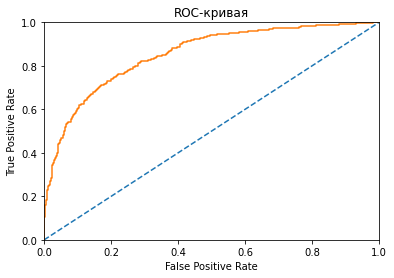

In [42]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Выводы

На тестовой выборке f1-мера равна 0.61, roc-auc равна 0.85. Таким образом выполнена задача по доведению f1-меры до значения не меньше 0.59. Это было достигнуто благодаря достижению баланса классов с помощью взвешивания классов